In [52]:
import pandas as pd
from sklearn.model_selection import train_test_split
import mlflow
import mlflow.sklearn
import pycaret.classification as pc
from sklearn.metrics import log_loss, confusion_matrix, ConfusionMatrixDisplay
from mlflow.tracking import MlflowClient
from mlflow.models.signature import infer_signature, ModelSignature
from mlflow.types.schema import Schema, ColSpec
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt


In [30]:
mlflow.set_tracking_uri("sqlite:///mlruns.db")
mlflow.set_registry_uri("sqlite:///mlruns.db")

experiment_name = 'ProjetoEngML'
experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment is None:
    experiment_id = mlflow.create_experiment(experiment_name)
    experiment = mlflow.get_experiment(experiment_id)
experiment_id = experiment.experiment_id

################################################################################################################################################################################

PREPARAÇÃO DOS DADOS

In [31]:
with mlflow.start_run(experiment_id=experiment_id, run_name = 'PreparacaoDados'):
    test_size = 0.2
    kobe_shots_dev = pd.read_parquet('../data/raw/dataset_kobe_dev.parquet')
    #kobe_shots_prod = pd.read_parquet('../data/raw/dataset_kobe_prod.parquet')
    kobe_shots_dev = kobe_shots_dev.dropna()
    #kobe_shots_prod = kobe_shots_prod.dropna()
    vars_interesse = ['lat', 'lon', 'minutes_remaining', 'period', 'playoffs', 'shot_distance', 'shot_made_flag']
    var_alvo = 'shot_made_flag'
    kobe_shots_dev = kobe_shots_dev[vars_interesse]
    #kobe_shots_prod = kobe_shots_prod[vars_interesse]
    kobe_shots_dev.to_parquet('../data/processed/data_filtered.parquet')
    x_train, x_test, y_train, y_test = train_test_split(kobe_shots_dev[['lat', 'lon', 'minutes_remaining', 'period', 'playoffs', 'shot_distance']],
                                                        kobe_shots_dev[var_alvo],
                                                         test_size=test_size,
                                                          stratify=kobe_shots_dev[var_alvo])
    base_train = pd.concat([x_train, y_train], axis=1)
    base_test = pd.concat([x_test, y_test], axis=1)
    base_train.to_parquet('../data/processed/base_train.parquet')
    base_test.to_parquet('../data/processed/base_teste.parquet')

    mlflow.log_params({'percent_test': test_size,
                       'variaveis': vars_interesse})
    mlflow.log_metrics({
        'num_linhas_base_treino': base_train.shape[0],
        'num_linhas_base_teste': base_test.shape[0]
    })


TREINAMENTO DO MODELO

In [32]:
mlflow.end_run()

In [33]:
with mlflow.start_run(experiment_id=experiment_id, run_name = 'Treinamento'):
    experiment = pc.setup(
        data = base_train,
        target = 'shot_made_flag',
        test_data = base_test,
        categorical_features = ['period', 'playoffs'],
        #normalize = True,
        #transformation = True,
        #remove_multicollinearity = True,
        #multicollinearity_threshold = 0.9,
        fold_strategy = 'stratifiedkfold',
        fold = 8,
        log_experiment = False,
        group_features = None
    )
    experiment.add_metric('log_loss', 'Log Loss', log_loss, greater_is_better = False)
    list_models = experiment.compare_models(['lr', 'dt'], n_select = 2)
    results = experiment.pull()
    mlflow.log_metrics({
            'log_loss_linear_regr': results['Log Loss']['lr'],
            'log_loss_decision_tree': results['Log Loss']['dt'],
            'f1_score_decision_tree': results.F1['dt']
        })
    registered_model_name = 'modelo_kobe_shots'
    model_version = -1
    nexamples = 5
    best_model = experiment.compare_models(n_select = 1, sort='f1', include=['lr', 'dt'] )
    tuned_model = pc.tune_model(best_model,
                            optimize = 'f1',
                            search_library = 'scikit-learn',
                            search_algorithm = 'random',
                            n_iter = 5)
    
    experiment.evaluate_model(tuned_model)
    pred_tuned = experiment.predict_model(tuned_model, raw_score=True)  
    #cm = confusion_matrix(pred_tuned.prediction_label, base_test['shot_made_flag'])  
    #calibrated_model = experiment.calibrate_model(tuned_model, method='sigmoid', calibrate_fold=5, fold=5)
    #pc.plot_model(calibrated_model, plot='calibration')
    #final_model = experiment.finalize_model(calibrated_model)
    final_model = experiment.finalize_model(tuned_model)
    pred_final = experiment.predict_model(final_model, raw_score=True)

    pred_final.to_parquet('../data/processed/prediction_final_dev.parquet')
    mlflow.log_artifact('../data/processed/prediction_final_dev.parquet')

    pc.save_model(final_model, f'./{registered_model_name}')
    model_pipe = experiment.load_model(f'./{registered_model_name}')
    model_features = vars_interesse[:-1]
    inf_signature = infer_signature(x_train[model_features], model_pipe.predict(x_train))
    input_example = {x: x_train[x].values[:nexamples] for x in model_features}
    mlflow.sklearn.log_model(
            sk_model=model_pipe,
            artifact_path="sklearn-model",
            registered_model_name=registered_model_name,
            signature = inf_signature,
            input_example = input_example,
            #pyfunc_predict_fn = 'predict_proba'
        )
    client = MlflowClient()
    if model_version == -1:
        model_version = client.get_latest_versions(registered_model_name)[-1].version
    client.set_registered_model_alias(
        name = registered_model_name, 
        alias = "staging", 
        version = model_version
    )

,Description,Value
0,Session id,1503
1,Target,shot_made_flag
2,Target type,Binary
3,Original data shape,"(20285, 7)"
4,Transformed data shape,"(20285, 13)"
5,Transformed train set shape,"(16228, 13)"
6,Transformed test set shape,"(4057, 13)"
7,Numeric features,4
8,Categorical features,2
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Log Loss,TT (Sec)
lr,Logistic Regression,0.5759,0.0000,0.4812,0.5659,0.5200,0.1446,0.1462,6.7609,0.9362
dt,Decision Tree Classifier,0.5375,0.0000,0.5869,0.5137,0.5477,0.0789,0.0796,7.3729,0.6088


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Log Loss,TT (Sec)
dt,Decision Tree Classifier,0.5375,0.0000,0.5869,0.5137,0.5477,0.0789,0.0796,7.3729,0.0538
lr,Logistic Regression,0.5759,0.0000,0.4812,0.5659,0.5200,0.1446,0.1462,6.7609,0.4950


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Log Loss
Fold,,,,,,,,
0,0.5668,0.0000,0.4256,0.5605,0.4839,0.1225,0.1259,6.9065
1,0.5761,0.0000,0.4370,0.5732,0.4959,0.1416,0.1455,6.7572
2,0.5476,0.0000,0.4376,0.5320,0.4802,0.0863,0.0876,7.2130
3,0.5885,0.0000,0.4303,0.5957,0.4997,0.1653,0.1717,6.5608
4,0.5715,0.0000,0.4246,0.5685,0.4861,0.1317,0.1358,6.8313
5,0.5666,0.0000,0.3657,0.5719,0.4461,0.1175,0.1255,6.9099
6,0.5804,0.0000,0.4721,0.5734,0.5178,0.1525,0.1548,6.6898
7,0.5843,0.0000,0.4514,0.5834,0.5090,0.1587,0.1626,6.6269
Mean,0.5727,0.0000,0.4305,0.5698,0.4898,0.1345,0.1387,6.8119


Fitting 8 folds for each of 5 candidates, totalling 40 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Log Loss
0,Decision Tree Classifier,0.5413,0.5197,0.5736,0.5177,0.5442,0.0850,0.0854,7.3130


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Log Loss
0,Decision Tree Classifier,0.9211,0.9824,0.9732,0.8755,0.9218,0.8427,0.8475,1.2575


Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Loaded


Registered model 'modelo_kobe_shots' already exists. Creating a new version of this model...
Created version '2' of model 'modelo_kobe_shots'.


################################################################################################################################################################################

COMENTÁRIOS SOBRE A PREPARAÇÃO DOS DADOS

In [34]:
kobe_shots_dev = pd.read_parquet('../data/raw/dataset_kobe_dev.parquet')
kobe_shots_prod = pd.read_parquet('../data/raw/dataset_kobe_prod.parquet')

In [35]:
kobe_shots_dev.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24271 entries, 0 to 30696
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   action_type         24271 non-null  object 
 1   combined_shot_type  24271 non-null  object 
 2   game_event_id       24271 non-null  int64  
 3   game_id             24271 non-null  int64  
 4   lat                 24271 non-null  float64
 5   loc_x               24271 non-null  int64  
 6   loc_y               24271 non-null  int64  
 7   lon                 24271 non-null  float64
 8   minutes_remaining   24271 non-null  int64  
 9   period              24271 non-null  int64  
 10  playoffs            24271 non-null  int64  
 11  season              24271 non-null  object 
 12  seconds_remaining   24271 non-null  int64  
 13  shot_distance       24271 non-null  int64  
 14  shot_made_flag      20285 non-null  float64
 15  shot_type           24271 non-null  object 
 16  shot_zone

Para a base de desenvolvimento, há 24271 linhas de dados. Todas as variáveis estão preenchidas para todas as linhas, exceto a variável shot_made_flag, para a qual apenas 20285 linhas estão preenchidas. As linhas sem essa informação, que será considerada como o alvo da classificação, serão removidas da base de desenvolvimento.

In [36]:
kobe_shots_prod.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6426 entries, 10 to 30695
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   action_type         6426 non-null   object 
 1   combined_shot_type  6426 non-null   object 
 2   game_event_id       6426 non-null   int64  
 3   game_id             6426 non-null   int64  
 4   lat                 6426 non-null   float64
 5   loc_x               6426 non-null   int64  
 6   loc_y               6426 non-null   int64  
 7   lon                 6426 non-null   float64
 8   minutes_remaining   6426 non-null   int64  
 9   period              6426 non-null   int64  
 10  playoffs            6426 non-null   int64  
 11  season              6426 non-null   object 
 12  seconds_remaining   6426 non-null   int64  
 13  shot_distance       6426 non-null   int64  
 14  shot_made_flag      5412 non-null   float64
 15  shot_type           6426 non-null   object 
 16  shot_zone

A mesma consideração pode ser feita para a base de Produção, que será usada ao final do projeto, com o modelo servido. Nem todas as linhas contém a classificação indicada pela variável shot_made_flag, e irei remover as linhas sem essa informação. As demais variáveis estão todas presentes em toda a base.

In [37]:
kobe_shots_dev = kobe_shots_dev.dropna()
kobe_shots_prod = kobe_shots_prod.dropna()

In [38]:
display(kobe_shots_dev.info())
display(kobe_shots_prod.info())

<class 'pandas.core.frame.DataFrame'>
Index: 20285 entries, 1 to 30696
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   action_type         20285 non-null  object 
 1   combined_shot_type  20285 non-null  object 
 2   game_event_id       20285 non-null  int64  
 3   game_id             20285 non-null  int64  
 4   lat                 20285 non-null  float64
 5   loc_x               20285 non-null  int64  
 6   loc_y               20285 non-null  int64  
 7   lon                 20285 non-null  float64
 8   minutes_remaining   20285 non-null  int64  
 9   period              20285 non-null  int64  
 10  playoffs            20285 non-null  int64  
 11  season              20285 non-null  object 
 12  seconds_remaining   20285 non-null  int64  
 13  shot_distance       20285 non-null  int64  
 14  shot_made_flag      20285 non-null  float64
 15  shot_type           20285 non-null  object 
 16  shot_zone

None

<class 'pandas.core.frame.DataFrame'>
Index: 5412 entries, 10 to 30695
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   action_type         5412 non-null   object 
 1   combined_shot_type  5412 non-null   object 
 2   game_event_id       5412 non-null   int64  
 3   game_id             5412 non-null   int64  
 4   lat                 5412 non-null   float64
 5   loc_x               5412 non-null   int64  
 6   loc_y               5412 non-null   int64  
 7   lon                 5412 non-null   float64
 8   minutes_remaining   5412 non-null   int64  
 9   period              5412 non-null   int64  
 10  playoffs            5412 non-null   int64  
 11  season              5412 non-null   object 
 12  seconds_remaining   5412 non-null   int64  
 13  shot_distance       5412 non-null   int64  
 14  shot_made_flag      5412 non-null   float64
 15  shot_type           5412 non-null   object 
 16  shot_zone

None

In [39]:
x_train, x_test, y_train, y_test = train_test_split(kobe_shots_dev[['lat', 'lon', 'minutes_remaining', 'period', 'playoffs', 'shot_distance']],
                                                        kobe_shots_dev[var_alvo],
                                                         test_size=test_size,
                                                          stratify=kobe_shots_dev[var_alvo])

In [40]:
props = pd.DataFrame(kobe_shots_dev[var_alvo].value_counts(normalize=True))
props['train'] = y_train.value_counts(normalize=True).values
props['test'] = y_test.value_counts(normalize=True).values
props

,proportion,train,test
shot_made_flag,,,
0.0,0.522652,0.522677,0.522554
1.0,0.477348,0.477323,0.477446


In [41]:
best_model

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, random_state=1503, splitter='best')

In [46]:
final_model.get_params()

{'memory': Memory(location=None),
 'steps': [('numerical_imputer',
   TransformerWrapper(exclude=None,
                      include=['lat', 'lon', 'minutes_remaining', 'shot_distance'],
                      transformer=SimpleImputer(add_indicator=False, copy=True,
                                                fill_value=None,
                                                keep_empty_features=False,
                                                missing_values=nan,
                                                strategy='mean'))),
  ('categorical_imputer',
   TransformerWrapper(exclude=None, include=['period', 'playoffs'],
                      transformer=SimpleImputer(add_indicator=False, copy=True,
                                                fill_value=None,
                                                keep_empty_features=False,
                                                missing_values=nan,
                                                strategy='most_frequent')))

In [50]:
kobe_shots_prod = pd.read_parquet('../data/raw/dataset_kobe_prod.parquet')
kobe_shots_prod = kobe_shots_prod.dropna()
kobe_shots_prod = kobe_shots_prod[vars_interesse]
prediction = final_model.predict(kobe_shots_prod[['lat', 'lon', 'minutes_remaining', 'period', 'playoffs', 'shot_distance']])
display(prediction)

array([1., 1., 0., ..., 0., 1., 0.], dtype=float32)

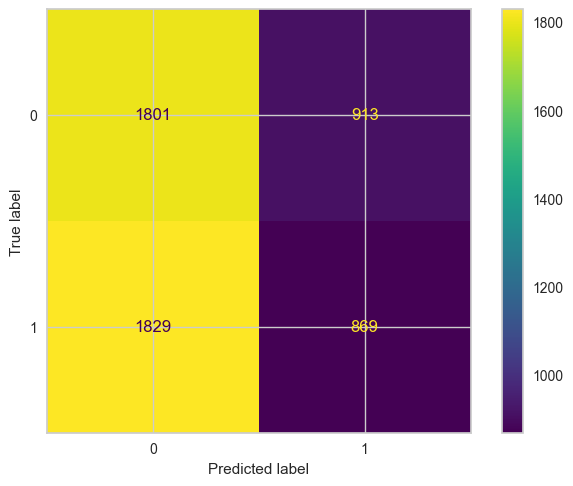

In [53]:
cm = confusion_matrix(prediction, kobe_shots_prod['shot_made_flag']) 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, )
disp.plot()
plt.show()

In [44]:
experiment.evaluate_model(list_models[0])

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…